<a href="https://colab.research.google.com/github/NirjharDebnath/Calculator/blob/main/CFAIR_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Tue Dec 17 01:20:15 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0             11W /   35W |     278MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [ ]:
train_dataset = datasets.CIFAR10(root='sample_data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='sample_data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_dataset, test_dataset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: sample_data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: sample_data
     Split: Test
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
            ))

In [ ]:
train_dataset.data.shape, test_dataset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## Data Visualisation

In [ ]:
class_names = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..0.7591222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0985878].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.8242395].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.075614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737

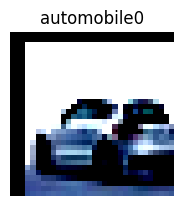

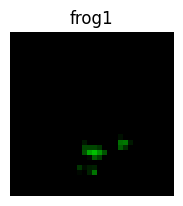

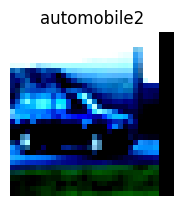

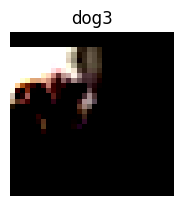

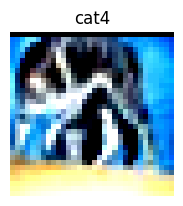

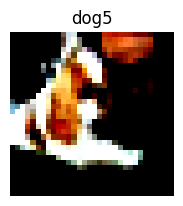

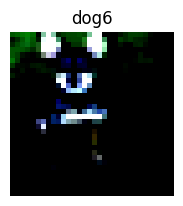

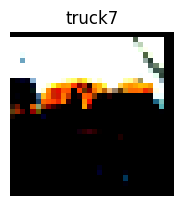

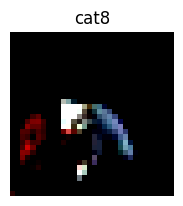

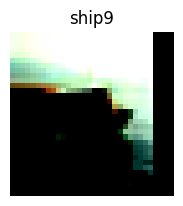

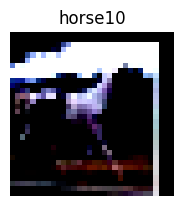

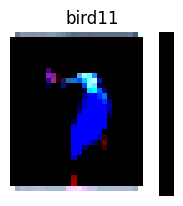

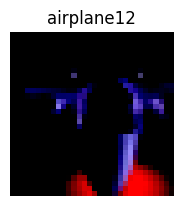

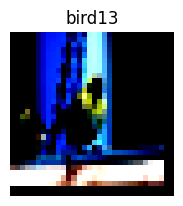

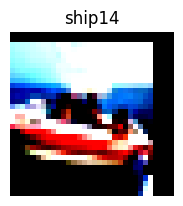

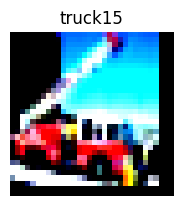

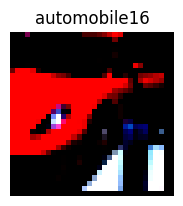

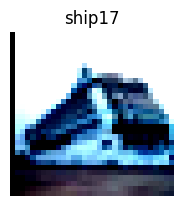

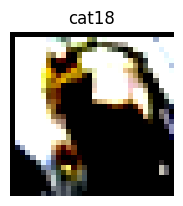

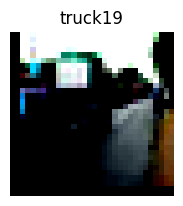

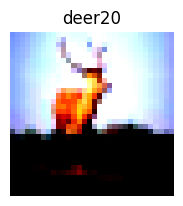

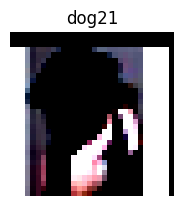

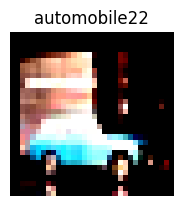

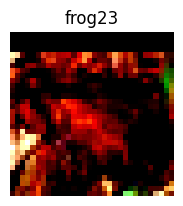

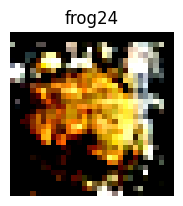

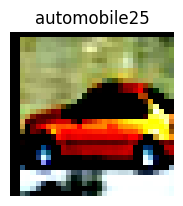

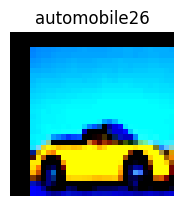

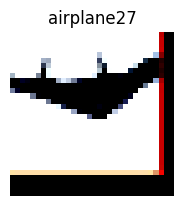

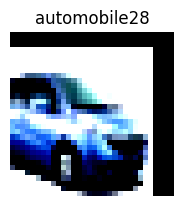

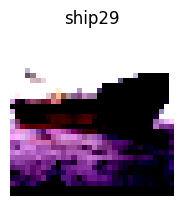

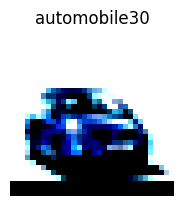

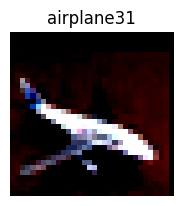

In [ ]:
image, label = next(iter(train_dataloader))
image.shape, label.shape
for i in range(32):
    plt.figure(figsize=(20, 20))
    plt.subplot(8, 4, i+1)
    plt.imshow(image[i].permute(1, 2, 0))
    plt.title(class_names[label[i]] + str(i))
    plt.axis('off')
# plt.imshow(image[0].permute(1, 2, 0))
# plt.title(class_names[label[0].item()])
# plt.show()

In [ ]:
image[0].permute(1, 2, 0).shape

torch.Size([32, 32, 3])

## Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

In [ ]:
torch.manual_seed(42)
class TINYVGG(nn.Module):
    def __init__(self, in_channels, hidden_units, output):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x


# model = TINYVGG(in_channels=3, hidden_units=10, output=10).to(device)

# Gives 50% TEST ACCURACY


In [ ]:
torch.manual_seed(42)
class TINYVGGMOD(nn.Module):
    def __init__(self, in_channels, hidden_units, output):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.resnetconv = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU()
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
                    nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
                    nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=hidden_units*8*8),
            nn.Linear(in_features=hidden_units*8*8, out_features=output)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.resnetconv(x) - x
        x = self.conv_block2(x)
        x = self.resnetconv(x) - x
        x = self.classifier(x)
        return x


# model = TINYVGGMOD(in_channels=3, hidden_units=12, output=10).to(device)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU(inplace=True)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward (self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__ (self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.Linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # print(out.shape)
        out = self.avg_pool(out)
        # print(out.shape)
        out = out.view(out.size(0), -1)
        # out = out.reshape(out.size(0), -1)
        out = self.Linear(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock, [3, 3, 3])


torch.manual_seed(42)
model = ResNet18().to(device)

In [ ]:
test_image = torch.randn(3, 32, 32)
test_image2 = torch.randn(32, 32, 3)
test_image.shape
# plt.imshow(test_image)
output = model(test_image.unsqueeze(0).to(device))
output.shape

torch.Size([1, 10])

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)


        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
timeron = timer()

# Train and test model
EPOCHS = 20
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

timeroff = timer()
print(f"Total time taken on {device} : {timeroff-timeron}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.83992 | Train accuracy: 32.56%


  5%|▌         | 1/20 [00:19<06:07, 19.34s/it]

Test loss: 1.57536 | Test accuracy: 42.08%

Epoch: 1
---------
Train loss: 1.77561 | Train accuracy: 34.44%


 10%|█         | 2/20 [00:38<05:45, 19.18s/it]

Test loss: 1.60857 | Test accuracy: 40.93%

Epoch: 2
---------
Train loss: 1.51506 | Train accuracy: 44.46%


 15%|█▌        | 3/20 [00:57<05:26, 19.23s/it]

Test loss: 1.41372 | Test accuracy: 48.38%

Epoch: 3
---------
Train loss: 1.39396 | Train accuracy: 49.80%


 20%|██        | 4/20 [01:17<05:08, 19.29s/it]

Test loss: 1.36344 | Test accuracy: 51.45%

Epoch: 4
---------
Train loss: 1.30343 | Train accuracy: 53.24%


 25%|██▌       | 5/20 [01:35<04:46, 19.10s/it]

Test loss: 1.21782 | Test accuracy: 56.53%

Epoch: 5
---------
Train loss: 1.23847 | Train accuracy: 55.81%


 30%|███       | 6/20 [01:54<04:25, 18.99s/it]

Test loss: 1.37730 | Test accuracy: 51.61%

Epoch: 6
---------
Train loss: 1.17067 | Train accuracy: 58.32%


 35%|███▌      | 7/20 [02:13<04:05, 18.89s/it]

Test loss: 1.14521 | Test accuracy: 59.82%

Epoch: 7
---------
Train loss: 1.12930 | Train accuracy: 60.32%


 40%|████      | 8/20 [02:32<03:47, 18.97s/it]

Test loss: 1.25219 | Test accuracy: 54.58%

Epoch: 8
---------
Train loss: 1.10076 | Train accuracy: 61.25%


 45%|████▌     | 9/20 [02:51<03:27, 18.91s/it]

Test loss: 1.11145 | Test accuracy: 60.86%

Epoch: 9
---------
Train loss: 1.04756 | Train accuracy: 63.41%


 50%|█████     | 10/20 [03:09<03:08, 18.86s/it]

Test loss: 1.02190 | Test accuracy: 63.99%

Epoch: 10
---------
Train loss: 1.00718 | Train accuracy: 64.66%


 55%|█████▌    | 11/20 [03:28<02:49, 18.87s/it]

Test loss: 1.01955 | Test accuracy: 64.56%

Epoch: 11
---------
Train loss: 0.98797 | Train accuracy: 65.56%


 60%|██████    | 12/20 [03:47<02:31, 18.90s/it]

Test loss: 1.07805 | Test accuracy: 62.91%

Epoch: 12
---------
Train loss: 0.97071 | Train accuracy: 66.24%


 65%|██████▌   | 13/20 [04:06<02:12, 18.88s/it]

Test loss: 1.03385 | Test accuracy: 64.85%

Epoch: 13
---------
Train loss: 0.95696 | Train accuracy: 66.58%


 70%|███████   | 14/20 [04:26<01:54, 19.12s/it]

Test loss: 1.12290 | Test accuracy: 61.06%

Epoch: 14
---------
Train loss: 0.94352 | Train accuracy: 67.01%


 75%|███████▌  | 15/20 [04:45<01:35, 19.02s/it]

Test loss: 0.87427 | Test accuracy: 69.11%

Epoch: 15
---------
Train loss: 0.92969 | Train accuracy: 67.57%


 80%|████████  | 16/20 [05:04<01:16, 19.11s/it]

Test loss: 0.89714 | Test accuracy: 68.69%

Epoch: 16
---------
Train loss: 0.91670 | Train accuracy: 68.28%


 85%|████████▌ | 17/20 [05:23<00:57, 19.04s/it]

Test loss: 0.86165 | Test accuracy: 70.33%

Epoch: 17
---------
Train loss: 0.91914 | Train accuracy: 67.97%


 90%|█████████ | 18/20 [05:42<00:37, 18.95s/it]

Test loss: 0.82153 | Test accuracy: 71.39%

Epoch: 18
---------
Train loss: 0.90488 | Train accuracy: 68.61%


 95%|█████████▌| 19/20 [06:00<00:18, 18.89s/it]

Test loss: 0.90482 | Test accuracy: 67.77%

Epoch: 19
---------
Train loss: 0.90094 | Train accuracy: 68.76%


100%|██████████| 20/20 [06:19<00:00, 18.98s/it]

Test loss: 0.89764 | Test accuracy: 69.42%

Total time taken on cuda : 379.63545909100003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7261518..2.0663116].


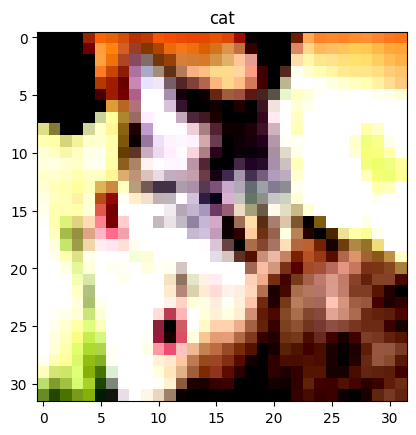

The Model Predicted This Image As : cat


In [ ]:
# torch.manual_seed(42)
i = np.random.randint(0, 10)
image, label = next(iter(test_dataloader))
image.shape, label.shape
plt.imshow(image[i].permute(1, 2, 0))
plt.title(class_names[label[i].item()])
plt.show()


output = model(image[i].unsqueeze(0).to(device))
print(f"The Model Predicted This Image As : {class_names[torch.argmax(output, dim=1)]}")

## THIS CODE IS STILL IN PROGRESS